# Import Libraries

In [1]:
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from statistics import mode
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Import dataset

In [2]:
df = pd.read_csv("cwdata.csv")
df.head()

Income Post-code Employed Home Owner Education Gender Balance Age  Colour  \
0   10500        C4      NaN          N    School      F     300  25  Yellow   
1   26525        G5        Y          N   College   Male    3500  25   Green   
2    8230        A1        N          N    School      F    1250  25     Red   
3   25000        S5        N          N        U       F    6755  19  Yellow   
4   15250        G7       No          N    School   Male     810  23     Red   

  Fraud  
0     N  
1     N  
2     1  
3     Y  
4     Y

# Find Unique Data

In [3]:
print(df["Employed"].unique())
print(df["Education"].unique())
print(df["Gender"].unique())
print(df["Fraud"].unique())
print(df["Colour"].unique())

[nan 'Y' 'N' 'No' 'Yes']
['School' 'College' 'U ' 'University' 'S' 'S ' 'Coll' 'C ' 'Uni ' nan
 'Coll ' 'U' ' ' 'Uni']
['F' 'Male' 'Female' 'M' nan]
['N' '1' 'Y' 'Yes' 'No' '0']
['Yellow' 'Green' 'Red' 'Purple' 'Blue' 'Pink' 'Res']


# Data Cleaning & Encoding

encoding as a bool

In [4]:
df["Employed"].replace(["Y", "Yes", "N", "No"],[1, 1, 0, 0], inplace = True)
print(df["Employed"].unique())

[nan  1.  0.]


Education is encoded as a numeric value, as university is more educated than college, college is more educated than school.

In [5]:
df["Education"].replace(["School", "S", "S ", "College", "Coll", "Coll ", "C ", "University", "U", "U ", "Uni", "Uni ", " "],[0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, np.NaN], inplace = True)
print(df["Education"].unique())

[ 0.  1.  2. nan]


bool for gender, 0 and 1 arbitrarily female and male

In [6]:
df["Gender"].replace(["F", "Female", "Male", "M"],[0, 0, 1, 1], inplace = True)
print(df["Gender"].unique())

[ 0.  1. nan]


bool - fraud == true or false
same for homeowner

In [7]:
df["Fraud"].replace(["N", "No", "0", "Y", "Yes", "1" ],[0, 0, 0, 1, 1, 1], inplace = True)
print(df["Fraud"].unique())

[0 1]


In [8]:
df["Home Owner"].replace(["N", "No", "Y", "Yes"],[0, 0, 1, 1], inplace = True)
print(df["Home Owner"].unique())

[ 0.  1. nan]


remove non-nuemeric values

In [9]:
df["Age"].replace([" "],[np.NaN], inplace = True)
df["Age"] = pd.to_numeric(df["Age"])
df["Balance"].replace([" "],[np.NaN], inplace = True)
df["Balance"]=pd.to_numeric(df["Balance"])

remove typo

In [10]:
df["Colour"].replace("Res","Red", inplace = True)
print(df["Colour"].unique())

['Yellow' 'Green' 'Red' 'Purple' 'Blue' 'Pink']


# Feature Analysis

Interlude - Is colour worth keeping? There may be an unseen correlation that gives us more data for our models

Isolate colour column + fraud

In [11]:
colours = df[["Colour", "Fraud"]]
colours

Colour  Fraud
0    Yellow      0
1     Green      0
2       Red      1
3    Yellow      1
4       Red      1
..      ...    ...
115  Yellow      0
116     Red      1
117     Red      1
118  Yellow      0
119     Red      1

[120 rows x 2 columns]

One hot encoding - to encode colours as nuemeric values would imply the wrong kind of relationship, i.e: red is not "more colour" than purple

In [12]:
colourDummies = pd.get_dummies(colours.Colour)
colours = pd.concat([colours, colourDummies], axis=1)
colours = colours.drop("Colour", axis = 1)
colours

Fraud  Blue  Green  Pink  Purple  Red  Yellow
0        0     0      0     0       0    0       1
1        0     0      1     0       0    0       0
2        1     0      0     0       0    1       0
3        1     0      0     0       0    0       1
4        1     0      0     0       0    1       0
..     ...   ...    ...   ...     ...  ...     ...
115      0     0      0     0       0    0       1
116      1     0      0     0       0    1       0
117      1     0      0     0       0    1       0
118      0     0      0     0       0    0       1
119      1     0      0     0       0    1       0

[120 rows x 7 columns]

Display Correlation

<Axes: >

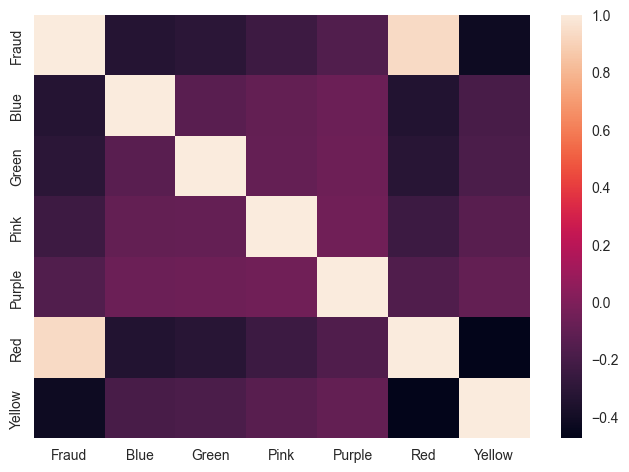

In [13]:
corr = colours.corr()
sb.heatmap(corr)

There is an inexplicably high correlation between the colour red and fraud, thus we will keep this collumn

In [14]:
red = colours[["Red"]]
df = pd.concat([df, red], axis=1)
df = df.drop("Colour", axis = 1)
df

Income Post-code  Employed  Home Owner  Education  Gender  Balance   Age  \
0     10500        C4       NaN         0.0        0.0     0.0    300.0  25.0   
1     26525        G5       1.0         0.0        1.0     1.0   3500.0  25.0   
2      8230        A1       0.0         0.0        0.0     0.0   1250.0  25.0   
3     25000        S5       0.0         0.0        2.0     0.0   6755.0  19.0   
4     15250        G7       0.0         0.0        0.0     1.0    810.0  23.0   
..      ...       ...       ...         ...        ...     ...      ...   ...   
115   45050        G8       1.0         1.0        2.0     1.0  54500.0  54.0   
116   11250        D4       0.0         0.0        0.0     0.0   3250.0  29.0   
117    7450        D1       0.0         0.0        1.0     1.0   4560.0  19.0   
118   12250        F5       0.0         0.0        2.0     0.0    300.0  25.0   
119    8450       NaN       0.0         0.0        0.0     1.0   2455.0  23.0   

     Fraud  Red  
0        0    0  
1        0    0  
2        1    1  
3        1    0  
4        1    1  
..     ...  ...  
115      0    0  
116      1    1  
117      1    1  
118      0    0  
119      1    1  

[120 rows x 10 columns]

Second interlude - is postcode worth keeping?

In [15]:
pc = df[["Post-code", "Fraud"]]
pc = pc.rename(columns = {'Post-code' : "PostCode"})
pc

PostCode  Fraud
0         C4      0
1         G5      0
2         A1      1
3         S5      1
4         G7      1
..       ...    ...
115       G8      0
116       D4      1
117       D1      1
118       F5      0
119      NaN      1

[120 rows x 2 columns]

In [16]:
pcDummies = pd.get_dummies(pc.PostCode)
pc = pd.concat([pc, pcDummies], axis=1)
pc = pc.drop("PostCode", axis = 1)
pc

Fraud  A1  A3  A4  A5  A7  B1  B2  B3  B5  ...  S7  S9  T5  T6  T9  V1  \
0        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2        1   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3        1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4        1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
..     ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
115      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
116      1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
117      1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
118      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
119      1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

     V3  V5  W3  W7  
0     0   0   0   0  
1     0   0   0   0  
2     0   0   0   0  
3     0   0   0   0  
4     0   0   0   0  
..   ..  ..  ..  ..  
115   0   0   0   0  
116   0   0   0   0  
117   0   0   0   0  
118   0   0   0   0  
119   0   0   0   0  

[120 rows x 80 columns]

<Axes: >

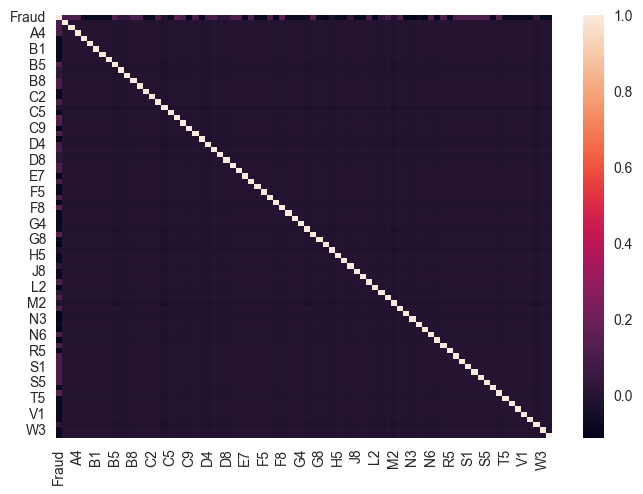

In [17]:
corr = pc.corr()
sb.heatmap(corr)

There are too many postcodes for any meaningful analysis to be found for this purpose + no clear correlation. This would just be unnecessary noise for our models. We will drop this collumn.

In [18]:
df = df.drop("Post-code", axis = 1)

In [19]:
df

Income  Employed  Home Owner  Education  Gender  Balance   Age  Fraud  \
0     10500       NaN         0.0        0.0     0.0    300.0  25.0      0   
1     26525       1.0         0.0        1.0     1.0   3500.0  25.0      0   
2      8230       0.0         0.0        0.0     0.0   1250.0  25.0      1   
3     25000       0.0         0.0        2.0     0.0   6755.0  19.0      1   
4     15250       0.0         0.0        0.0     1.0    810.0  23.0      1   
..      ...       ...         ...        ...     ...      ...   ...    ...   
115   45050       1.0         1.0        2.0     1.0  54500.0  54.0      0   
116   11250       0.0         0.0        0.0     0.0   3250.0  29.0      1   
117    7450       0.0         0.0        1.0     1.0   4560.0  19.0      1   
118   12250       0.0         0.0        2.0     0.0    300.0  25.0      0   
119    8450       0.0         0.0        0.0     1.0   2455.0  23.0      1   

     Red  
0      0  
1      0  
2      1  
3      0  
4      1  
..   ...  
115    0  
116    1  
117    1  
118    0  
119    1  

[120 rows x 9 columns]

Analysis of other features

<Axes: >

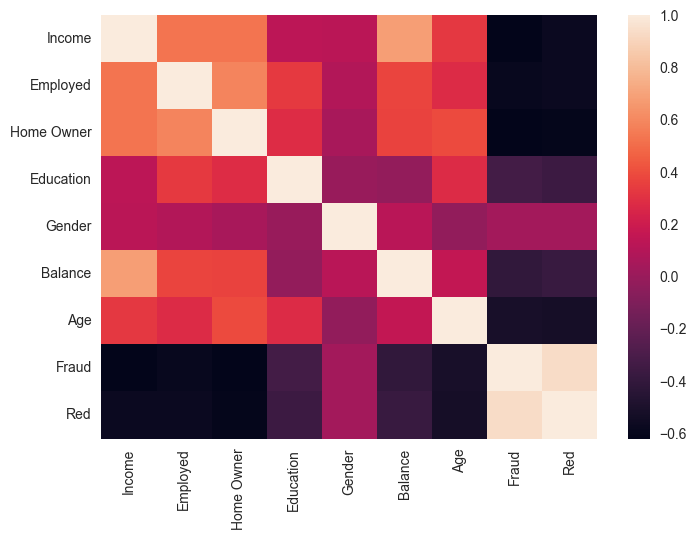

In [20]:
corr = df.corr()
sb.heatmap(corr)

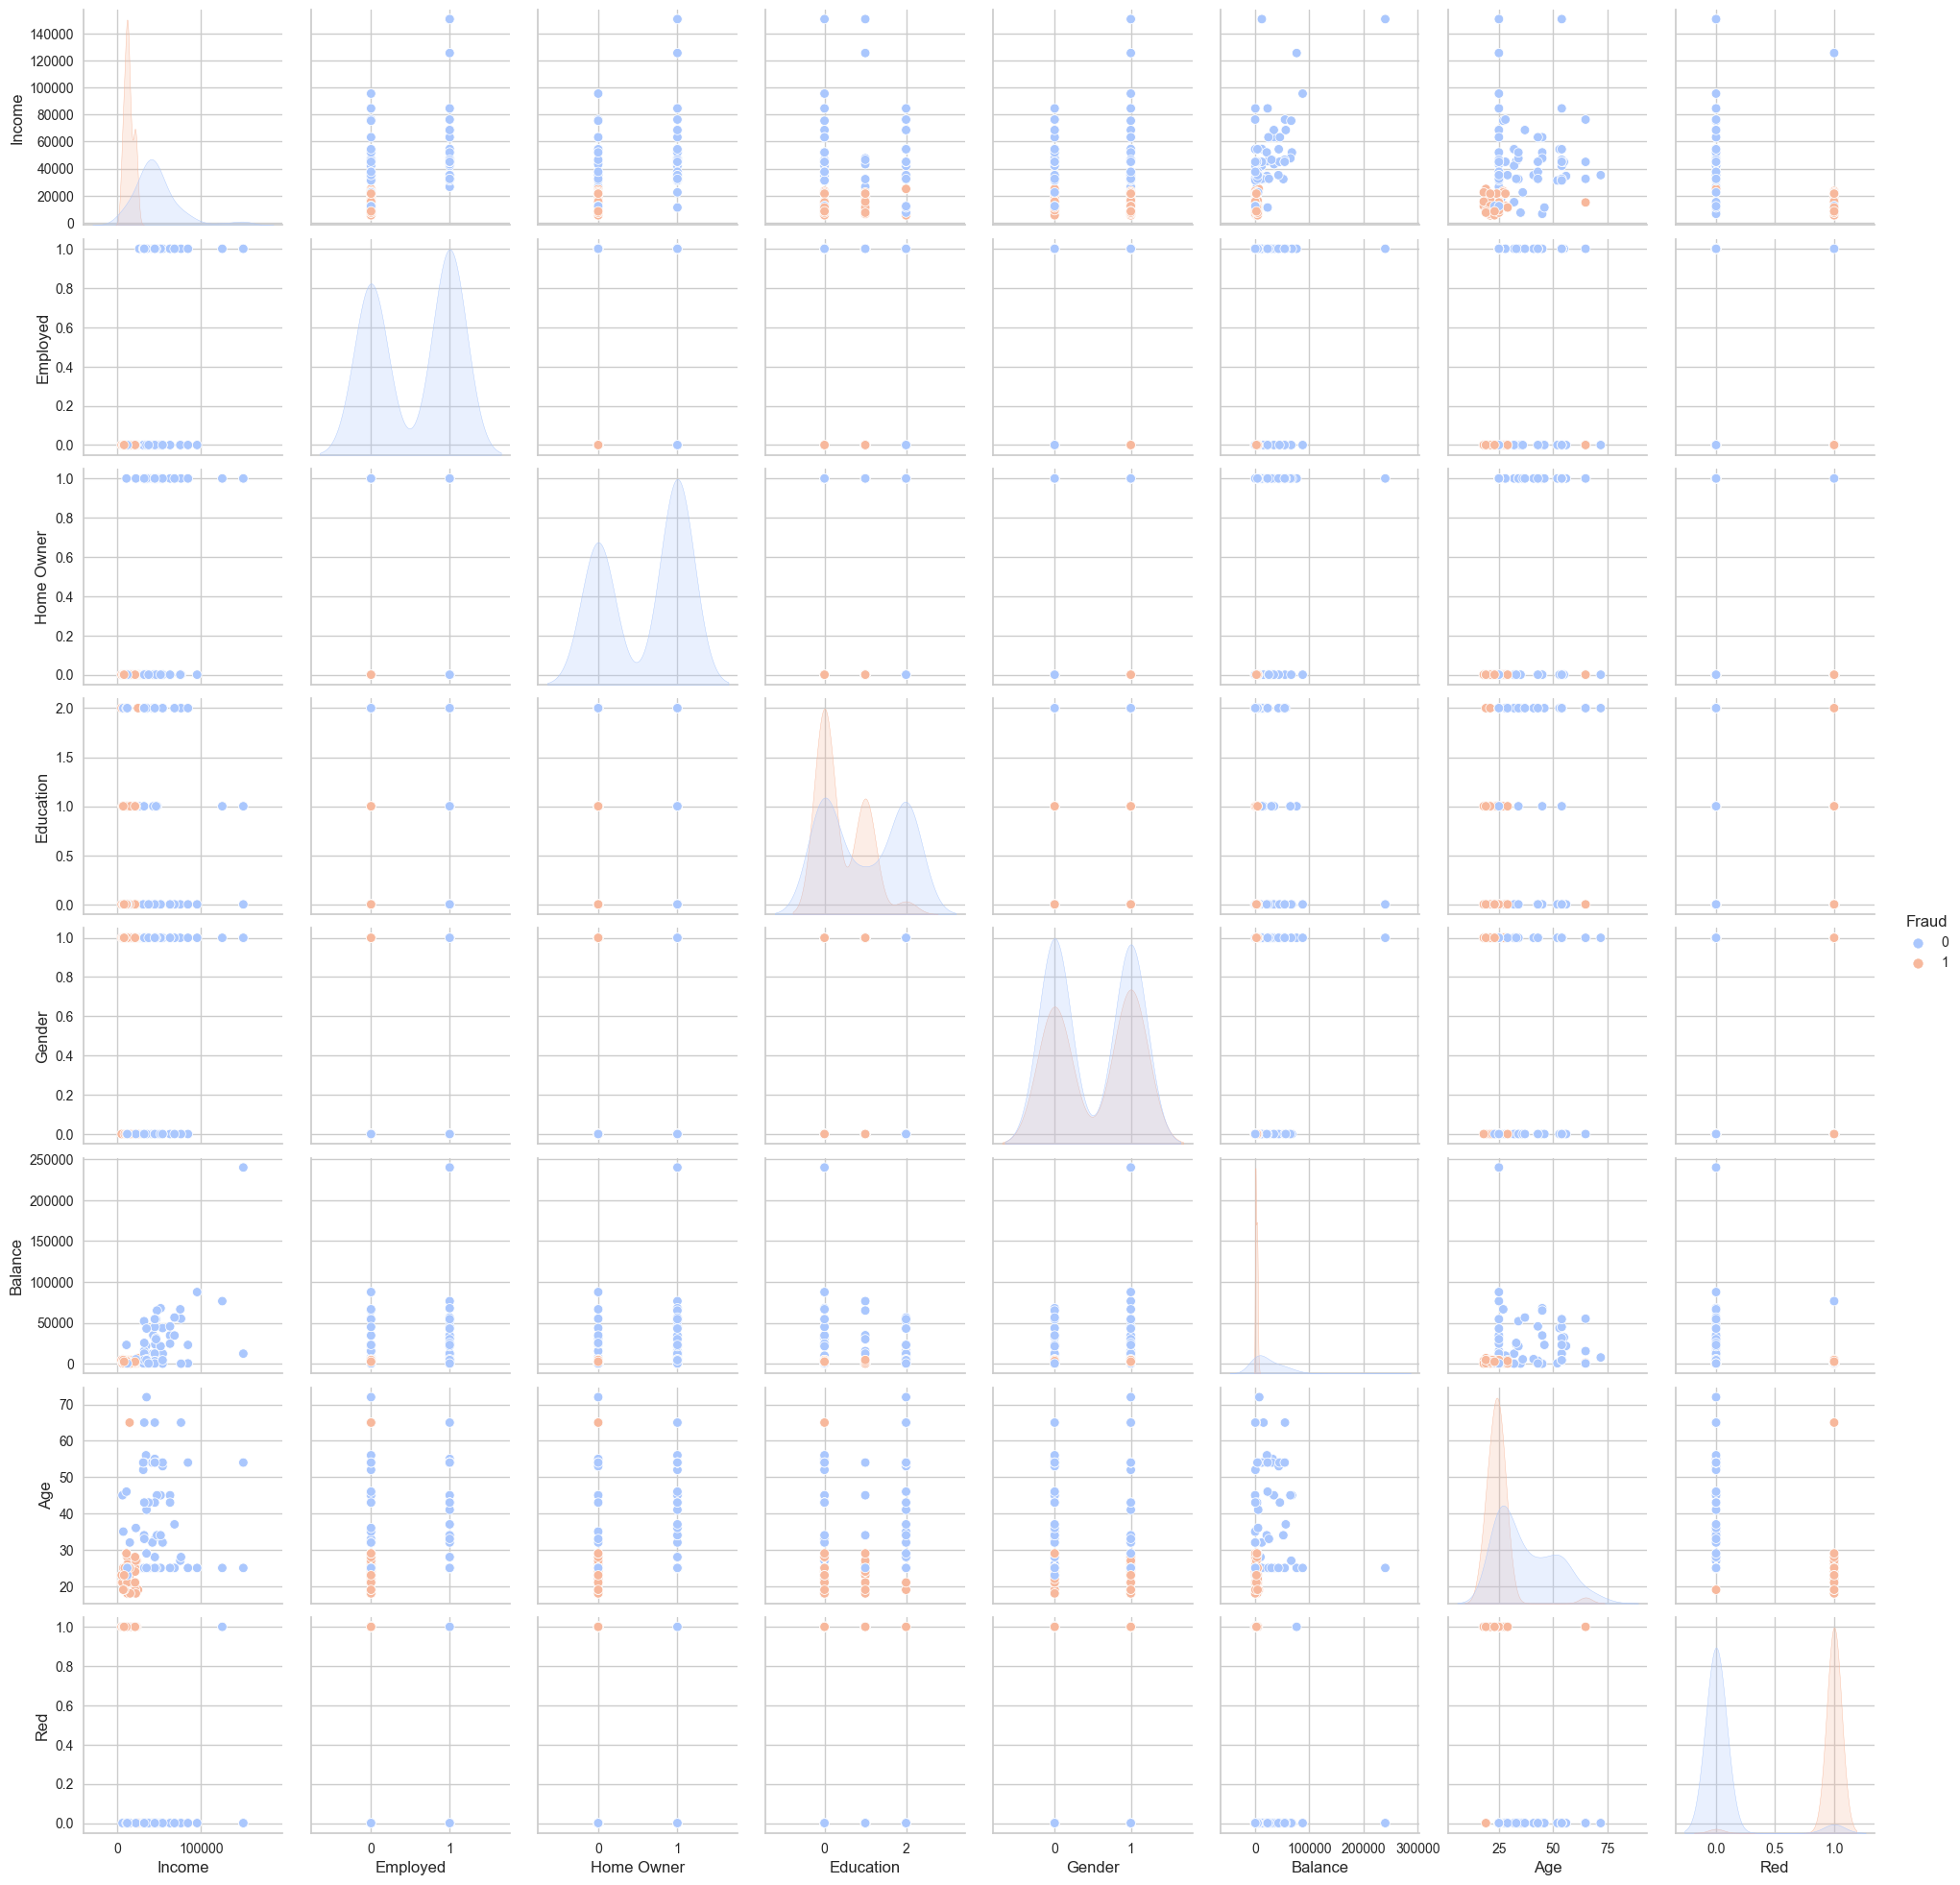

In [21]:
sb.pairplot(df, hue = "Fraud", palette='coolwarm')

cluster analysis - fraudsters tend to be younger, lower income, lower balance, less educated. None of them are homeowners.

<Axes: >

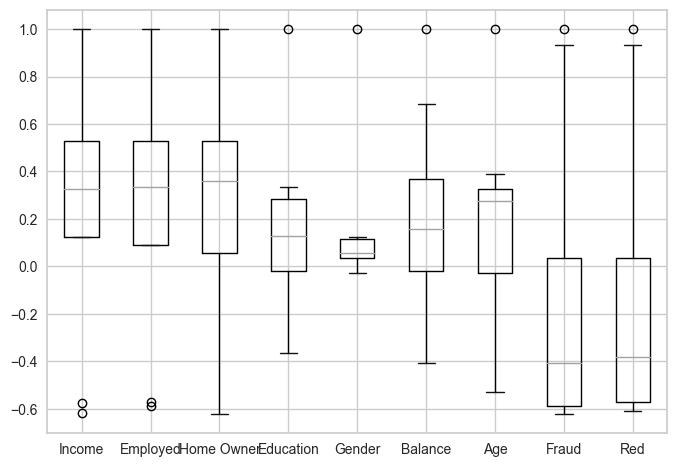

In [22]:
corr.boxplot()

Income, Employment, Home Ownership, and Age have high correlation. Education and balance have some weaker correlation. Gender has little to no correlation and can be removed.

In [23]:
df = df.drop("Gender", axis = 1)

In [24]:
df

Income  Employed  Home Owner  Education  Balance   Age  Fraud  Red
0     10500       NaN         0.0        0.0    300.0  25.0      0    0
1     26525       1.0         0.0        1.0   3500.0  25.0      0    0
2      8230       0.0         0.0        0.0   1250.0  25.0      1    1
3     25000       0.0         0.0        2.0   6755.0  19.0      1    0
4     15250       0.0         0.0        0.0    810.0  23.0      1    1
..      ...       ...         ...        ...      ...   ...    ...  ...
115   45050       1.0         1.0        2.0  54500.0  54.0      0    0
116   11250       0.0         0.0        0.0   3250.0  29.0      1    1
117    7450       0.0         0.0        1.0   4560.0  19.0      1    1
118   12250       0.0         0.0        2.0    300.0  25.0      0    0
119    8450       0.0         0.0        0.0   2455.0  23.0      1    1

[120 rows x 8 columns]

# Removing null values

In [25]:
df[df.isnull().any(axis=1)]

Income  Employed  Home Owner  Education  Balance   Age  Fraud  Red
0     10500       NaN         0.0        0.0    300.0  25.0      0    0
20    15230       0.0         NaN        NaN      NaN  32.0      0    0
34    54350       NaN         0.0        2.0  43575.0  53.0      0    0
35    42130       0.0         NaN        0.0    650.0  32.0      0    0
44    15600       0.0         NaN        0.0      0.0  24.0      1    1
52     8650       0.0         0.0        1.0      NaN  21.0      1    1
54    47650       1.0         1.0        1.0      NaN  34.0      0    0
61     6550       0.0         0.0        NaN      0.0  45.0      0    0
62    52000       0.0         0.0        0.0      NaN  25.0      0    0
77    45000       1.0         1.0        2.0   3200.0   NaN      0    0
83    31240       1.0         0.0        0.0      NaN  54.0      0    0
101   22450       0.0         1.0        NaN   5400.0  36.0      0    0
107   32480       1.0         0.0        NaN  25450.0  33.0      0    0
112   32450       1.0         1.0        2.0      NaN  43.0      0    0

<Axes: >

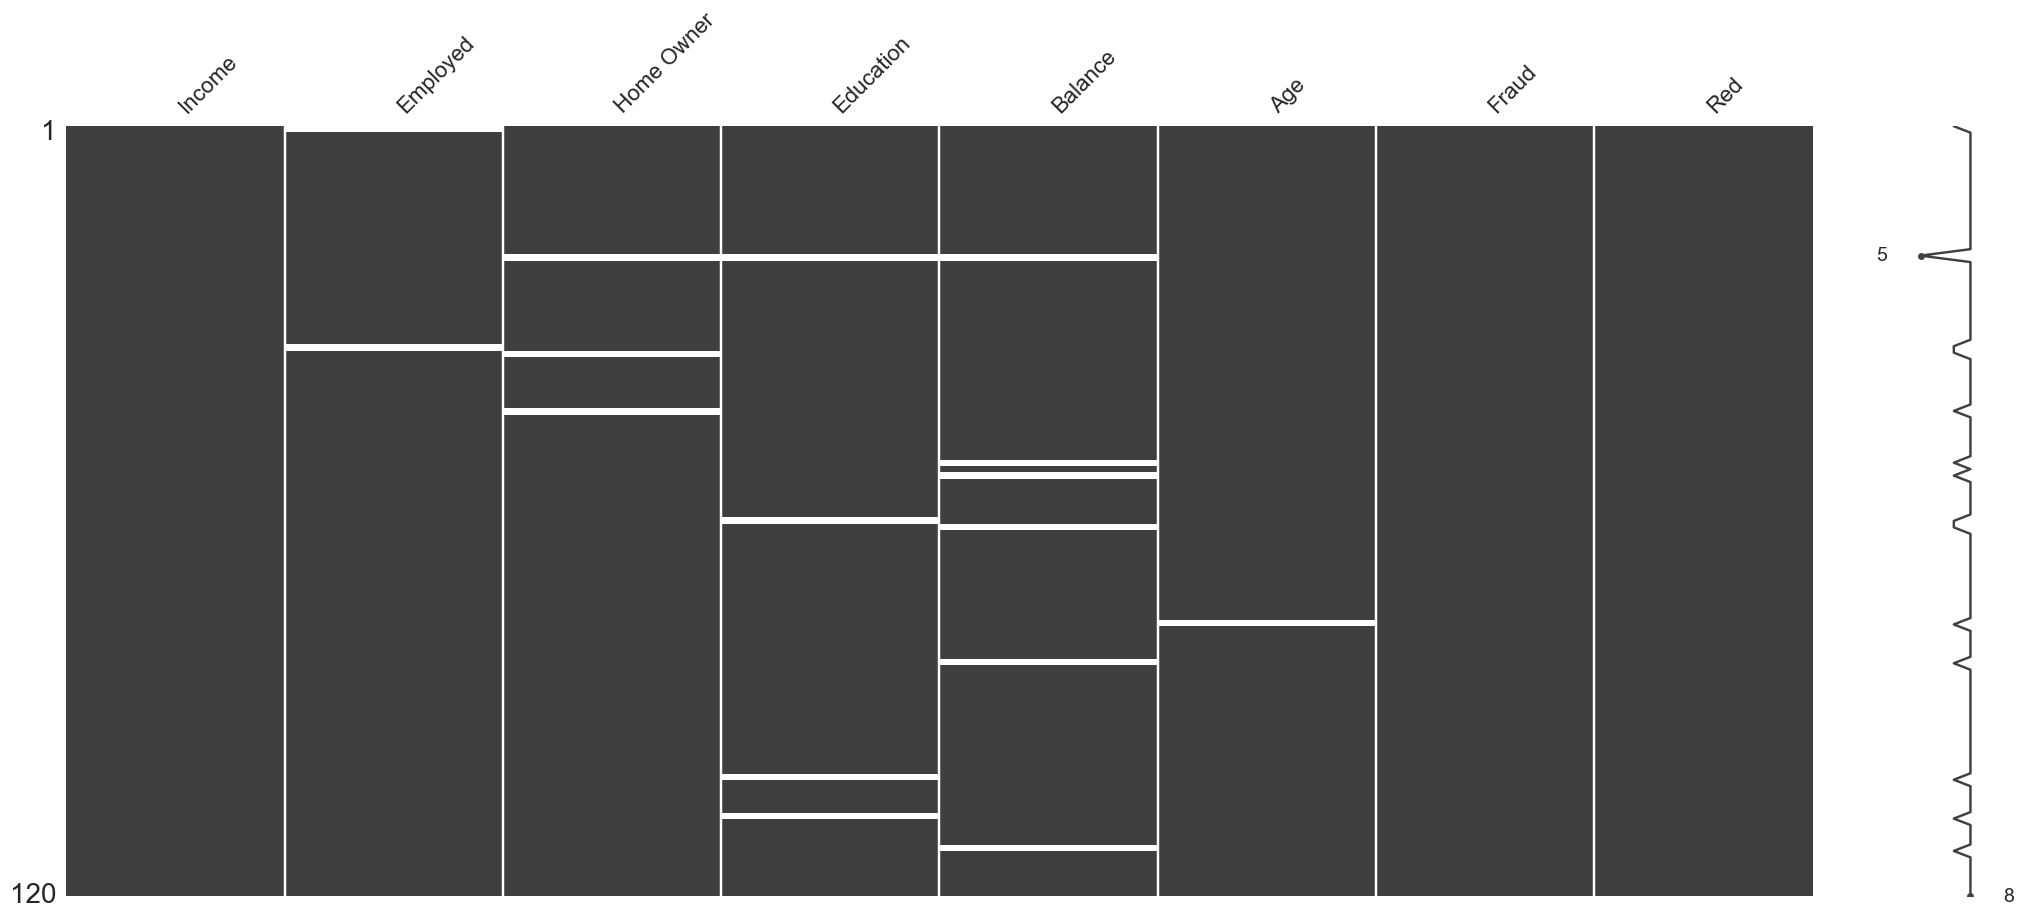

In [26]:
msno.matrix(df)

Rows with fraud + null homeowner value can be substituted as none of them in dataset own houses 

In [27]:
df.loc[df['Fraud'] == 1, 'Home Owner'].fillna(0, inplace=True)

fraud vs non-fraud columns have different means for values such as balance, income, and age

In [28]:
fraudMean = df.loc[df['Fraud'] == 1, 'Balance'].mean()
noFraudMean = df.loc[df['Fraud'] == 0, 'Balance'].mean()
print(fraudMean, noFraudMean)

2163.725490196078 25888.571428571428


In [29]:
df.loc[df['Fraud'] == 1, 'Balance'].fillna(fraudMean, inplace=True)
df.loc[df['Fraud'] == 0, 'Balance'].fillna(noFraudMean, inplace=True)
df

Income  Employed  Home Owner  Education  Balance   Age  Fraud  Red
0     10500       NaN         0.0        0.0    300.0  25.0      0    0
1     26525       1.0         0.0        1.0   3500.0  25.0      0    0
2      8230       0.0         0.0        0.0   1250.0  25.0      1    1
3     25000       0.0         0.0        2.0   6755.0  19.0      1    0
4     15250       0.0         0.0        0.0    810.0  23.0      1    1
..      ...       ...         ...        ...      ...   ...    ...  ...
115   45050       1.0         1.0        2.0  54500.0  54.0      0    0
116   11250       0.0         0.0        0.0   3250.0  29.0      1    1
117    7450       0.0         0.0        1.0   4560.0  19.0      1    1
118   12250       0.0         0.0        2.0    300.0  25.0      0    0
119    8450       0.0         0.0        0.0   2455.0  23.0      1    1

[120 rows x 8 columns]

In [30]:
fraudMean = df.loc[df['Fraud'] == 1, 'Income'].mean()
noFraudMean = df.loc[df['Fraud'] == 0, 'Income'].mean()
print(fraudMean, noFraudMean)

13891.634615384615 47264.92647058824


In [31]:
df.loc[df['Fraud'] == 1, 'Income'].fillna(fraudMean, inplace=True)
df.loc[df['Fraud'] == 0, 'Income'].fillna(noFraudMean, inplace=True)
df

Income  Employed  Home Owner  Education  Balance   Age  Fraud  Red
0     10500       NaN         0.0        0.0    300.0  25.0      0    0
1     26525       1.0         0.0        1.0   3500.0  25.0      0    0
2      8230       0.0         0.0        0.0   1250.0  25.0      1    1
3     25000       0.0         0.0        2.0   6755.0  19.0      1    0
4     15250       0.0         0.0        0.0    810.0  23.0      1    1
..      ...       ...         ...        ...      ...   ...    ...  ...
115   45050       1.0         1.0        2.0  54500.0  54.0      0    0
116   11250       0.0         0.0        0.0   3250.0  29.0      1    1
117    7450       0.0         0.0        1.0   4560.0  19.0      1    1
118   12250       0.0         0.0        2.0    300.0  25.0      0    0
119    8450       0.0         0.0        0.0   2455.0  23.0      1    1

[120 rows x 8 columns]

In [32]:
fraudMean = df.loc[df['Fraud'] == 1, 'Age'].mean()
noFraudMean = df.loc[df['Fraud'] == 0, 'Age'].mean()
print(fraudMean, noFraudMean)

24.46153846153846 37.656716417910445


In [33]:
df.loc[df['Fraud'] == 1, 'Age'].fillna(fraudMean, inplace=True)
df.loc[df['Fraud'] == 0, 'Age'].fillna(noFraudMean, inplace=True)
df

Income  Employed  Home Owner  Education  Balance   Age  Fraud  Red
0     10500       NaN         0.0        0.0    300.0  25.0      0    0
1     26525       1.0         0.0        1.0   3500.0  25.0      0    0
2      8230       0.0         0.0        0.0   1250.0  25.0      1    1
3     25000       0.0         0.0        2.0   6755.0  19.0      1    0
4     15250       0.0         0.0        0.0    810.0  23.0      1    1
..      ...       ...         ...        ...      ...   ...    ...  ...
115   45050       1.0         1.0        2.0  54500.0  54.0      0    0
116   11250       0.0         0.0        0.0   3250.0  29.0      1    1
117    7450       0.0         0.0        1.0   4560.0  19.0      1    1
118   12250       0.0         0.0        2.0    300.0  25.0      0    0
119    8450       0.0         0.0        0.0   2455.0  23.0      1    1

[120 rows x 8 columns]

fraud = less likely to be employed and vice versa

In [34]:
noFraudEmploy =df.loc[df['Fraud'] == 0, 'Employed']
noFraudEmploy.to_list()
fraudEmploy =df.loc[df['Fraud'] == 1, 'Employed']
fraudEmploy.to_list()
print(mode(fraudEmploy))
print(mode(noFraudEmploy))

0.0
1.0


In [35]:
df.loc[df['Fraud'] == 1, 'Employed'].fillna(0., inplace=True)
#df.loc[df['Fraud'] == 0, 'Employed'].fillna(1., inplace=True)
df

Income  Employed  Home Owner  Education  Balance   Age  Fraud  Red
0     10500       NaN         0.0        0.0    300.0  25.0      0    0
1     26525       1.0         0.0        1.0   3500.0  25.0      0    0
2      8230       0.0         0.0        0.0   1250.0  25.0      1    1
3     25000       0.0         0.0        2.0   6755.0  19.0      1    0
4     15250       0.0         0.0        0.0    810.0  23.0      1    1
..      ...       ...         ...        ...      ...   ...    ...  ...
115   45050       1.0         1.0        2.0  54500.0  54.0      0    0
116   11250       0.0         0.0        0.0   3250.0  29.0      1    1
117    7450       0.0         0.0        1.0   4560.0  19.0      1    1
118   12250       0.0         0.0        2.0    300.0  25.0      0    0
119    8450       0.0         0.0        0.0   2455.0  23.0      1    1

[120 rows x 8 columns]

Remove other NaN values 

<Axes: >

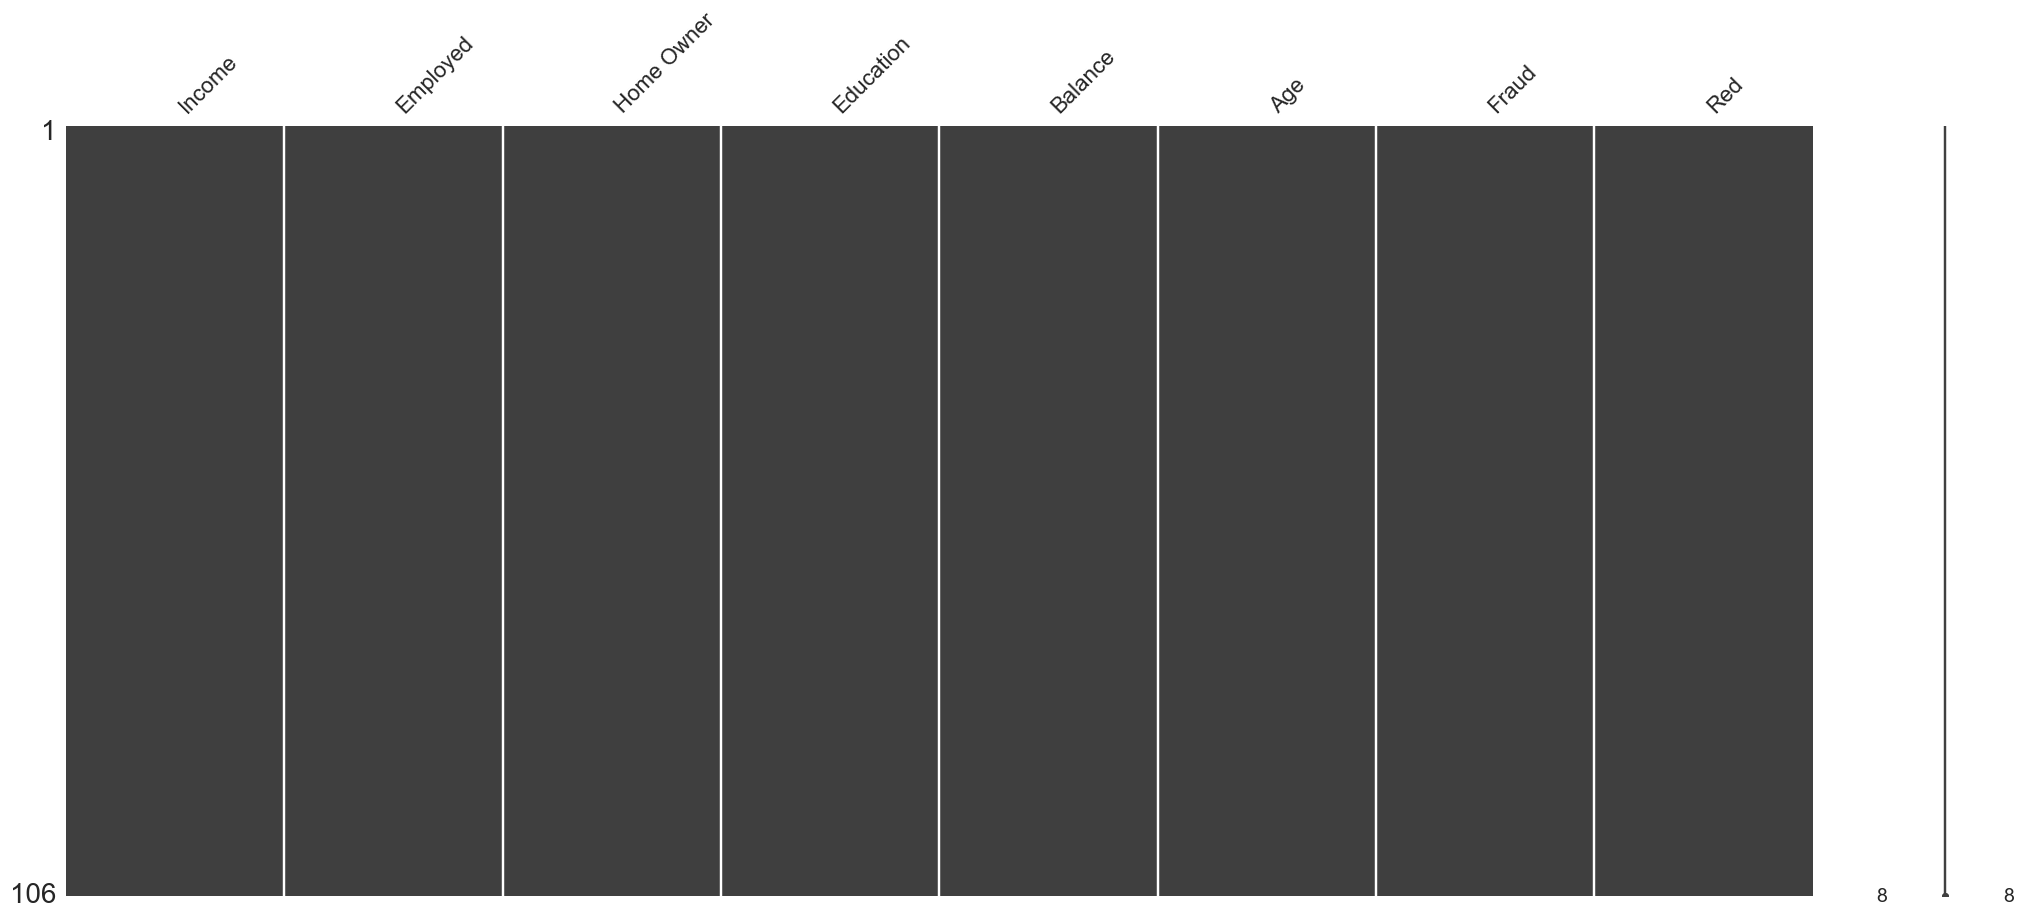

In [36]:
df = df.dropna() 
msno.matrix(df)

# Scale Data

In [37]:
scaler = MinMaxScaler()
scaledDf = scaler.fit_transform(df)
scaledDf = pd.DataFrame(scaledDf, columns = ["Income",	"Employed",	"Home Owner",	"Education",	"Balance",	"Age",	"Fraud", "Red"])
scaledDf

Income  Employed  Home Owner  Education   Balance       Age  Fraud  Red
0    0.145195       1.0         0.0        0.5  0.014583  0.129630    0.0  0.0
1    0.019153       0.0         0.0        0.0  0.005208  0.129630    1.0  1.0
2    0.134688       0.0         0.0        1.0  0.028146  0.018519    1.0  0.0
3    0.067516       0.0         0.0        0.0  0.003375  0.092593    1.0  1.0
4    0.251808       1.0         1.0        1.0  0.050000  0.666667    0.0  0.0
..        ...       ...         ...        ...       ...       ...    ...  ...
101  0.272821       1.0         1.0        1.0  0.227083  0.666667    0.0  0.0
102  0.039959       0.0         0.0        0.0  0.013542  0.203704    1.0  1.0
103  0.013779       0.0         0.0        0.5  0.019000  0.018519    1.0  1.0
104  0.046848       0.0         0.0        1.0  0.001250  0.129630    0.0  0.0
105  0.020668       0.0         0.0        0.0  0.010229  0.092593    1.0  1.0

[106 rows x 8 columns]

# Test Train Split

In [38]:
target = scaledDf["Fraud"]
features = scaledDf[["Income", "Employed", "Home Owner", "Education", "Balance", "Age"]]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3)

# Supervised

# KNN

In [40]:
n_neighbors = 5
classifier = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [41]:
predicted = classifier.predict(X_test)
print(X_test)
print(y_test)
print(predicted)

       Income  Employed  Home Owner  Education   Balance       Age
85   0.184637       1.0         1.0        1.0  0.216667  0.296296
66   0.076335       0.0         0.0        0.5  0.018542  0.055556
45   0.186221       1.0         0.0        1.0  0.000000  0.129630
24   0.033414       0.0         0.0        0.0  0.014958  0.055556
100  0.110575       0.0         0.0        0.5  0.009771  0.055556
29   0.290734       0.0         1.0        0.5  0.271000  0.500000
54   0.272477       1.0         1.0        1.0  0.051458  0.129630
101  0.272821       1.0         1.0        1.0  0.227083  0.666667
16   0.204960       0.0         0.0        1.0  0.031875  1.000000
63   0.039959       0.0         1.0        1.0  0.095833  0.518519
19   0.085704       0.0         0.0        0.5  0.005188  0.148148
75   0.272821       0.0         1.0        0.0  0.187500  0.666667
60   0.177678       0.0         1.0        0.0  0.002250  0.629630
48   0.047503       0.0         0.0        0.0  0.013521  0.12

In [42]:
accuracy = accuracy_score(y_test,predicted)
print(accuracy*100)

93.75


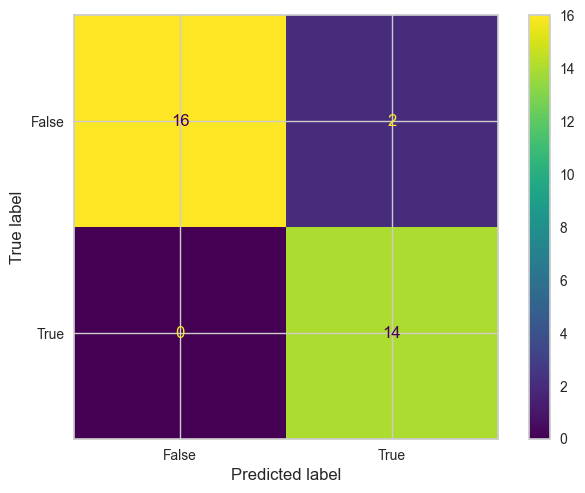

In [43]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

93% accuracy, however there were 2 false positives. False positives are far more harmful than false negatives. False negatives in this context would be people wrongfully labelled as committing fraud. 3 to 5 is the optimal value for K, as outside of this range the accuracy drops.

# Logistic Regression

In [44]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [45]:
y_predict = model.predict(X_test)
error = y_test-y_predict
error.describe()

count    32.000000
mean     -0.093750
std       0.296145
min      -1.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: Fraud, dtype: float64

In [46]:
accuracy = accuracy_score(y_test, y_predict)
print(accuracy*100)

90.625


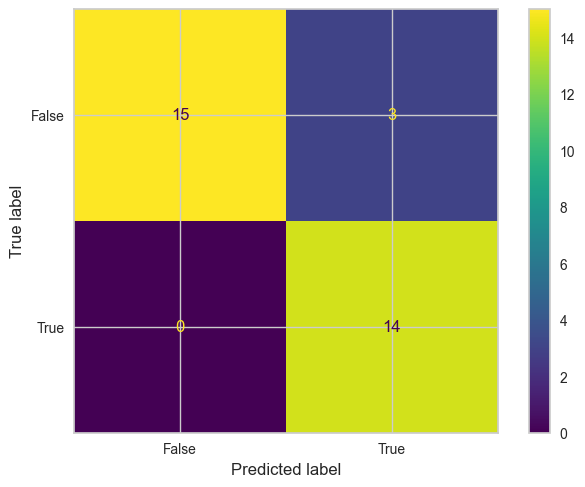

In [47]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

This model performed worse than KNN, with 87.5% accuracy and produced more false positives

# Descision Tree

In [48]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [49]:
accuracy = metrics.accuracy_score(y_test, y_pred)

In [50]:
print(accuracy * 100)

93.75


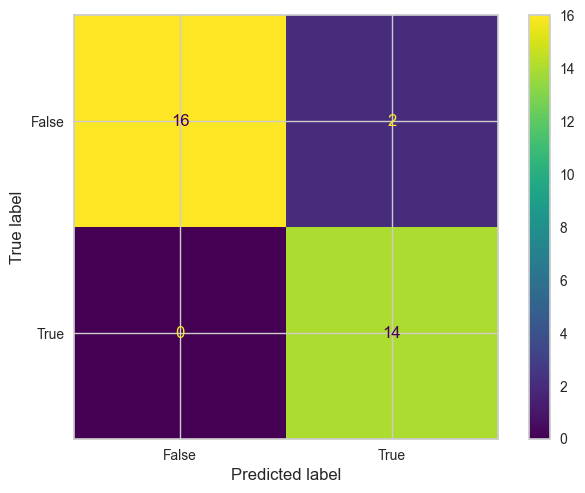

In [51]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

This model performed better than logistic regression, but worse than KNN.

# Unsupervised

# K-Means Clustering

For unsupervised learning we must remove the target

In [52]:
unlabeledData = scaledDf[['Income', 'Employed', 'Home Owner', 'Education', 'Balance', 'Age', 'Red']]
label = scaledDf["Fraud"]
unlabeledData

Income  Employed  Home Owner  Education   Balance       Age  Red
0    0.145195       1.0         0.0        0.5  0.014583  0.129630  0.0
1    0.019153       0.0         0.0        0.0  0.005208  0.129630  1.0
2    0.134688       0.0         0.0        1.0  0.028146  0.018519  0.0
3    0.067516       0.0         0.0        0.0  0.003375  0.092593  1.0
4    0.251808       1.0         1.0        1.0  0.050000  0.666667  0.0
..        ...       ...         ...        ...       ...       ...  ...
101  0.272821       1.0         1.0        1.0  0.227083  0.666667  0.0
102  0.039959       0.0         0.0        0.0  0.013542  0.203704  1.0
103  0.013779       0.0         0.0        0.5  0.019000  0.018519  1.0
104  0.046848       0.0         0.0        1.0  0.001250  0.129630  0.0
105  0.020668       0.0         0.0        0.0  0.010229  0.092593  1.0

[106 rows x 7 columns]

k = number of clusters.
This has been set to 2 as there are 2 outcomes we want to find: fraud or no fraud

In [53]:
k=2
kmeans = KMeans(n_clusters=k)
y = kmeans.fit_predict(unlabeledData)
y

C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

In [54]:
kmeans.cluster_centers_

array([[ 8.97208574e-02, -1.11022302e-16, -1.11022302e-16,
         1.84210526e-01,  2.44265351e-02,  1.39376218e-01,
         8.94736842e-01],
       [ 3.09333765e-01,  6.32653061e-01,  7.14285714e-01,
         5.71428571e-01,  1.12976190e-01,  3.78306878e-01,
         2.04081633e-02]])

C:\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


SilhouetteVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=2))

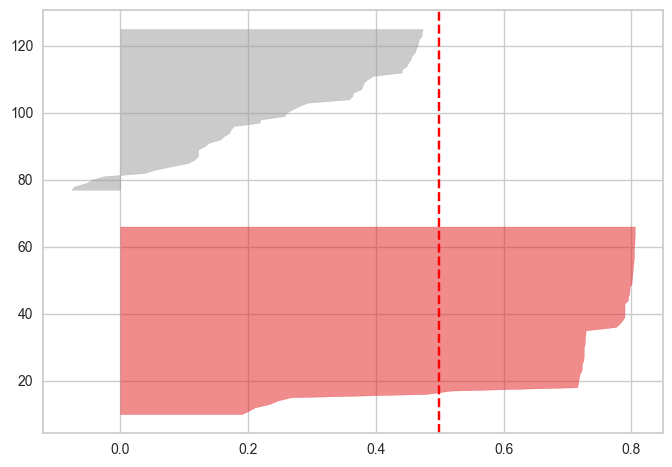

In [55]:
visModel = SilhouetteVisualizer(kmeans)
visModel.fit(unlabeledData)

In [56]:
silhouette_score_average = silhouette_score(unlabeledData, y)
print(silhouette_score_average * 100)

49.926635867624476


This suggests that K-means clustering is poorly suited for this task, as the silhouette score is far too low. If we refer back to the pairplot, we can see there is one graph with two very distinct clusters: age and red

In [57]:
unlabeledData = scaledDf[['Age', 'Red']]
unlabeledData

Age  Red
0    0.129630  0.0
1    0.129630  1.0
2    0.018519  0.0
3    0.092593  1.0
4    0.666667  0.0
..        ...  ...
101  0.666667  0.0
102  0.203704  1.0
103  0.018519  1.0
104  0.129630  0.0
105  0.092593  1.0

[106 rows x 2 columns]

In [58]:
k=2
kmeans = KMeans(n_clusters=k)
y = kmeans.fit_predict(unlabeledData)
y

C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [59]:
kmeans.cluster_centers_

array([[ 1.23219373e-01,  1.00000000e+00],
       [ 3.71742112e-01, -2.22044605e-16]])

C:\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


SilhouetteVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=2))

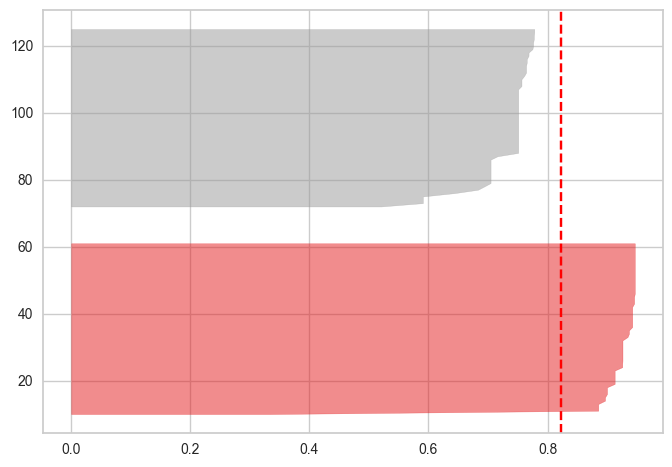

In [60]:
visModel = SilhouetteVisualizer(kmeans)
visModel.fit(unlabeledData)

In [61]:
silhouette_score_average = silhouette_score(unlabeledData, y)
print(silhouette_score_average * 100)

82.31765410990917


# TSNE Clustering

In [62]:
unlabeledData = scaledDf[['Income', 'Employed', 'Home Owner', 'Education', 'Balance', 'Age', 'Red']]
label = scaledDf["Fraud"]
unlabeledData

Income  Employed  Home Owner  Education   Balance       Age  Red
0    0.145195       1.0         0.0        0.5  0.014583  0.129630  0.0
1    0.019153       0.0         0.0        0.0  0.005208  0.129630  1.0
2    0.134688       0.0         0.0        1.0  0.028146  0.018519  0.0
3    0.067516       0.0         0.0        0.0  0.003375  0.092593  1.0
4    0.251808       1.0         1.0        1.0  0.050000  0.666667  0.0
..        ...       ...         ...        ...       ...       ...  ...
101  0.272821       1.0         1.0        1.0  0.227083  0.666667  0.0
102  0.039959       0.0         0.0        0.0  0.013542  0.203704  1.0
103  0.013779       0.0         0.0        0.5  0.019000  0.018519  1.0
104  0.046848       0.0         0.0        1.0  0.001250  0.129630  0.0
105  0.020668       0.0         0.0        0.0  0.010229  0.092593  1.0

[106 rows x 7 columns]

In [63]:
model = TSNE(learning_rate=100)

In [64]:
transformed = model.fit_transform(unlabeledData)

In [65]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

<Axes: >

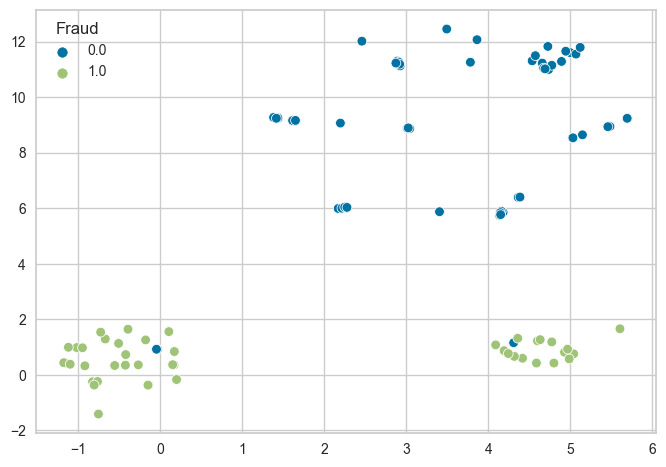

In [70]:
#sns.scatterplot(data=tips, x="total_bill", y="tip", hue="time")
sb.scatterplot(x=x_axis, y=y_axis, hue=label)

This model has produced three clusters